In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time, sys
from extra_geom import AGIPD_1MGeometry
import extra_data as ex
import h5netcdf
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [2]:
proposal = 900401
#run_no = 450

t134 = 422 #silica 20nm T = 1.3e-4
t785 = 450 #silica 20nm T = 7.8e-5 
t375 = 449 #silica 20nm T = 3.7e-5

t134_l = 425 #ludox T = 1.3e-4
t445_l = 445 #ludox T = 4.4e-5
t133_l = 446 #ludox T = 1.3e-3


qROI = range(14)

In [3]:
def get_data(run_no):
    
    qROI = range(14)

    loc = '/gpfs/exfel/exp/MID/202430/p{}/scratch/xpcs/r0'.format(proposal)
    outputloc = loc+str(run_no)+'/'

    TTCF = xr.open_dataarray(outputloc+'TTCF.nc')
    SAXS = xr.open_dataarray(outputloc+'SAXS.nc')
    g2 = xr.open_dataarray(outputloc+'g2.nc')
    pulseN = TTCF.pulse_1.values
    dt = pulseN[:-1]*222.5e-9 * 2
    q = np.array(TTCF.qBin[qROI])
    
    return TTCF, SAXS, g2, pulseN, dt, q

## Silica data

In [4]:
TTCF_134s, SAXS_134s, g2_134s, pulseN_134s, dt_134s, q_134s = get_data(t134)
TTCF_785s, SAXS_785s, g2_785s, pulseN_785s, dt_785s, q_785s = get_data(t785)
TTCF_375s, SAXS_375s, g2_375s, pulseN_375s, dt_375s, q_375s = get_data(t375)

## Ludox data

In [5]:
TTCF_134l, SAXS_134l, g2_134l, pulseN_134l, dt_134l, q_134l = get_data(t134_l)
TTCF_445l, SAXS_445l, g2_445l, pulseN_445l, dt_445l, q_445l = get_data(t445_l)
TTCF_133l, SAXS_133l, g2_133l, pulseN_133l, dt_133l, q_133l = get_data(t133_l)

## SAXS analysis

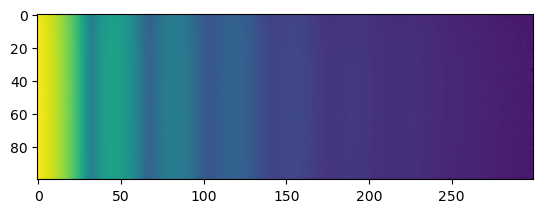

In [6]:
plt.imshow(np.log(SAXS_134s))

In [7]:
saxs_data_s = [SAXS_134s, SAXS_785s,SAXS_375s]
label_s = ['T = 1.3e-4', 'T = 7.8e-5', 'T = 3.7e-5']

saxs_data_l = [SAXS_134l, SAXS_445l, SAXS_133l]
label_l = ['T = 1.3e-4', 'T = 4.4e-5', 'T = 1.3e-3']

In [8]:
qq = SAXS_134s.coords['q'].values

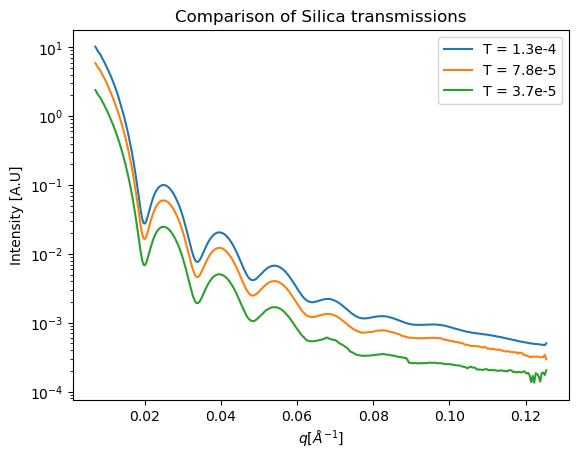

In [9]:
for i in range(len(saxs_data_s)):
    d = np.mean(saxs_data_s[i], axis = 0)
    plt.plot(qq, (d), label = label_s[i])
    plt.yscale('log')
    plt.legend()
    plt.xlabel(r'$q [Å^{-1}]$')
    plt.ylabel('Intensity [A.U]')
    plt.title('Comparison of Silica transmissions')
#plt.savefig('silica_comp.png', dpi = 300)

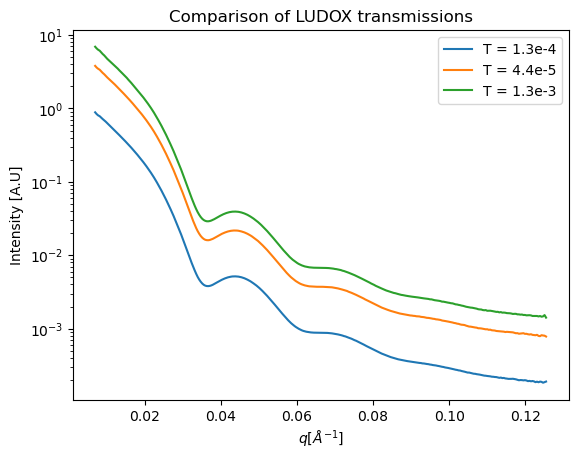

In [10]:
for i in range(len(saxs_data_l)):
    d = np.mean(saxs_data_l[i], axis = 0)
    plt.plot(qq, d, label = label_l[i])
    plt.yscale('log')
    plt.legend()
    plt.xlabel(r'$q [Å^{-1}]$')
    plt.ylabel('Intensity [A.U]')
    plt.title('Comparison of LUDOX transmissions')
#plt.savefig('ludox_comp.png', dpi = 300)

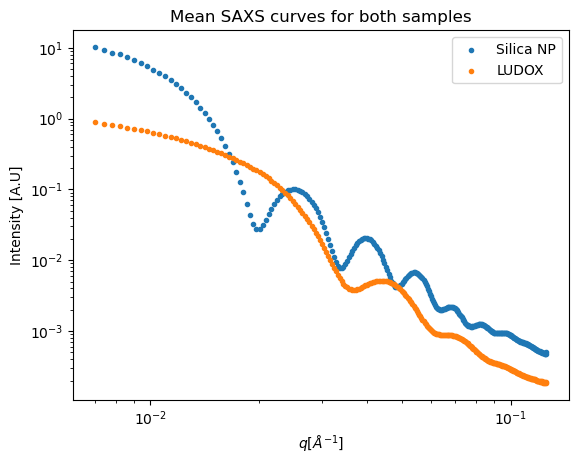

In [11]:
plt.scatter(qq, np.mean(saxs_data_s[0], axis = 0), label = 'Silica NP', marker = '.')
plt.scatter(qq, np.mean(saxs_data_l[0], axis = 0), label = 'LUDOX', marker = '.')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel('Intensity [A.U]')
plt.title('Mean SAXS curves for both samples')
plt.savefig('Sim/pics/saxs_both.png', dpi = 300)

In [12]:
g2s = [g2_134s, g2_785s,g2_375s]

g2l = [g2_134l, g2_445l, g2_133l]

tt = g2_134s.coords['t'].values

In [13]:
len(g2s[0])

14

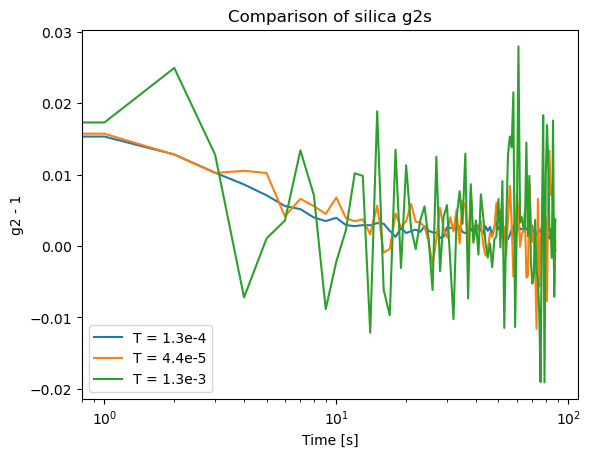

In [14]:
for i in range(len(g2s)):
    plt.plot(g2s[i][3], label = label_l[i])
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('g2 - 1')
    plt.title('Comparison of silica g2s')

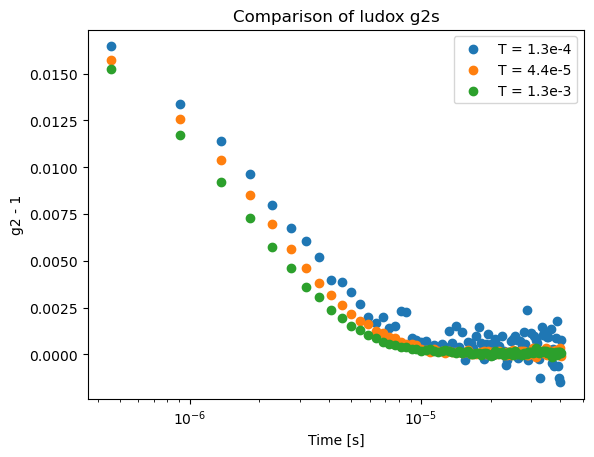

In [15]:
for i in range(len(g2s)):
    plt.scatter(tt, g2l[i][1], label = label_l[i])
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('g2 - 1')
    plt.title('Comparison of ludox g2s')

In [16]:
saxs_data_s[0]

<xarray.DataArray (pulseId: 100, q: 300)>
array([[8.878004e+00, 8.179547e+00, 7.458229e+00, ..., 3.922104e-04,
        4.056437e-04, 2.171633e-04],
       [9.388304e+00, 8.644377e+00, 7.886163e+00, ..., 4.676837e-04,
        4.420698e-04, 5.834191e-04],
       [9.249427e+00, 8.505875e+00, 7.769750e+00, ..., 4.475561e-04,
        4.241338e-04, 4.267738e-04],
       ...,
       [1.013097e+01, 9.340443e+00, 8.485137e+00, ..., 4.762661e-04,
        4.754124e-04, 5.977133e-04],
       [9.914960e+00, 9.121510e+00, 8.293678e+00, ..., 4.891367e-04,
        4.933717e-04, 4.861541e-04],
       [8.638923e+00, 7.909075e+00, 7.215745e+00, ..., 4.324083e-04,
        3.493689e-04, 3.449197e-04]], dtype=float32)
Coordinates:
  * pulseId  (pulseId) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * q        (q) float64 0.007022 0.007418 0.007814 ... 0.1246 0.125 0.1254

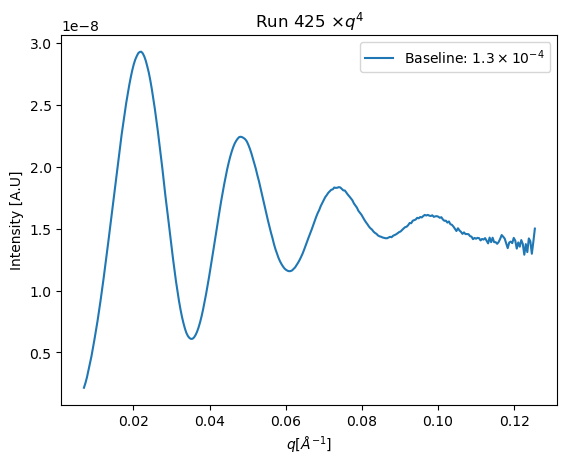

In [17]:
plt.plot(qq, (np.mean(saxs_data_l[0],axis = 0)- 1.3e-4) * qq**4, label = r'Baseline: $1.3 \times 10^{-4}$')
plt.title(r'Run 425 $\times q^{4}$')
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel('Intensity [A.U]')
plt.legend()
#plt.axhline(y = 1.3e-4 * qq**4)
#plt.savefig('Sim/pics/run_425_q4.png', dpi = 300)
#plt.legend()
#plt.xscale('log')
#plt.yscale('log')

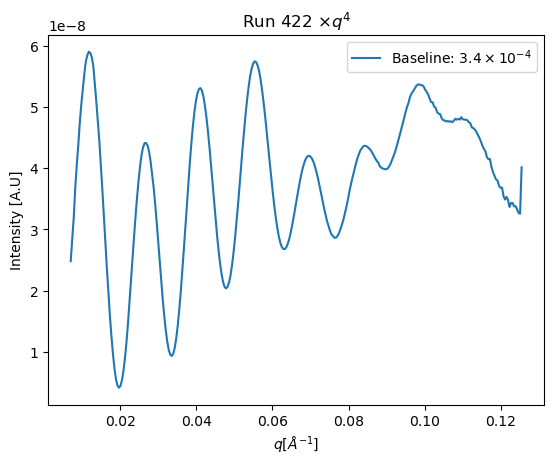

In [18]:
plt.plot(qq, (np.mean(saxs_data_s[0], axis = 0) - 3.4e-4) * qq**4, label = r'Baseline: $3.4 \times 10^{-4}$')
plt.title(r'Run 422 $\times q^{4}$')
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel('Intensity [A.U]')
plt.legend()
#plt.xscale('log')
#plt.savefig('Sim/pics/run_422_q4.png', dpi = 300)

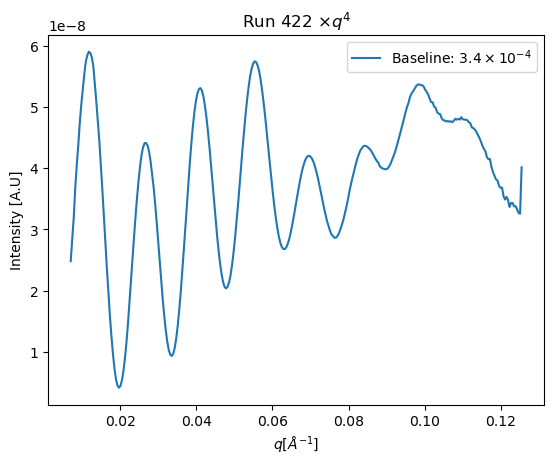

In [28]:
plt.plot(qq, (np.mean(saxs_data_s[0], axis = 0) - 3.4e-4) * qq**4, label = r'Baseline: $3.4 \times 10^{-4}$')
plt.title(r'Run 422 $\times q^{4}$')
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel('Intensity [A.U]')
plt.legend()